# Coding Project 1 : Linear Regression and Regularization

**Please write the names of all group members here:**




---


*Note:* The provided structure for the code below is only suggestive, and if you want to structure your programs differently you may do so.

### Question 1 - Importing the Data

In [1]:
#For Question 1, you can import the following packages:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection  import train_test_split

#### 1.a) 
Import the dataset Housing.csv into Python as a pandas DataFrame. To determine whether a variable is categorical or numerical, please refer to the file data_description.txt. Remember that the first column of the csv file is an index column and should not be considered as an explanatory variable.

#### Answer:

In [2]:
# First column of the csv file in an index column so we do not need it
data = pd.read_csv("Housing.csv")
data.drop(columns=['Id'],inplace=True)
# Seperatin the explanatory features from the target variable
X = data.drop(columns=["SalePrice"])
y = data["SalePrice"]

#### 1.b) 

Graphically determine whether the target variable SalePrice is approximately Gaussian. If not, suggest a suitable transformation to bring SalePrice closer to a Gaussian distribution (logarithmic, inverse, square-root, ...). Do not forget to apply this transformation to the target variable SalePrice in the dataset. Why is it important to consider such potential transformations?


#### Answer:

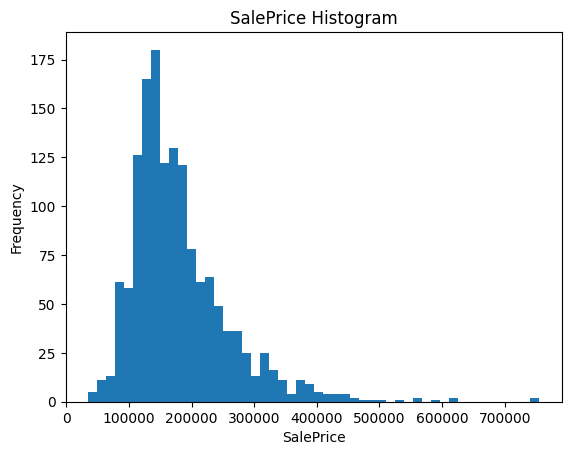

In [3]:
# Plot histogram of the target variable SalePrice
plt.hist(y, bins=50)
plt.title("SalePrice Histogram")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

We observe that the target variable SalePrice is not Gaussian but is strongly right skewed. Most houses sell at lower prices, while a few very large prices create a long right tail. Histogram's shape resembles a LogNormal distribution. We applied Log transformation, which is suited for right skewed data, by taking the natural logarithm of all data points. 

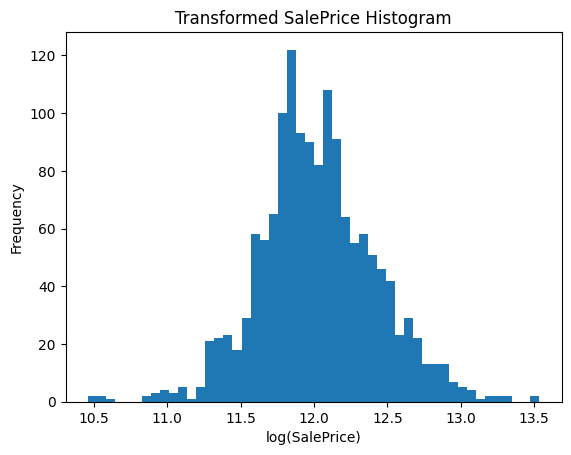

In [4]:
# We take natural logarithm of all data points in y
y_log = np.log(y)

# Plot histogram of the transformed target variable SalePrice
plt.hist(y_log, bins=50)
plt.title("Transformed SalePrice Histogram")
plt.xlabel("log(SalePrice)")
plt.ylabel("Frequency")
plt.show()


We observe that after applying the logarithmic transformation, the distribution of SalePrice looks much more symmetric and bell-shaped.  
The long right tail has been compressed, and the data now resembles a normal distribution much more closely.  

To confirm this observation, we compare the normality of the target variable before and after transformation by:  
1. Computing the sample skewness.  
2. Inspecting QQ-plots to see how closely the data follows a theoretical Gaussian distribution.

Skewness before log transform: 1.881
Skewness after log transform:  0.121


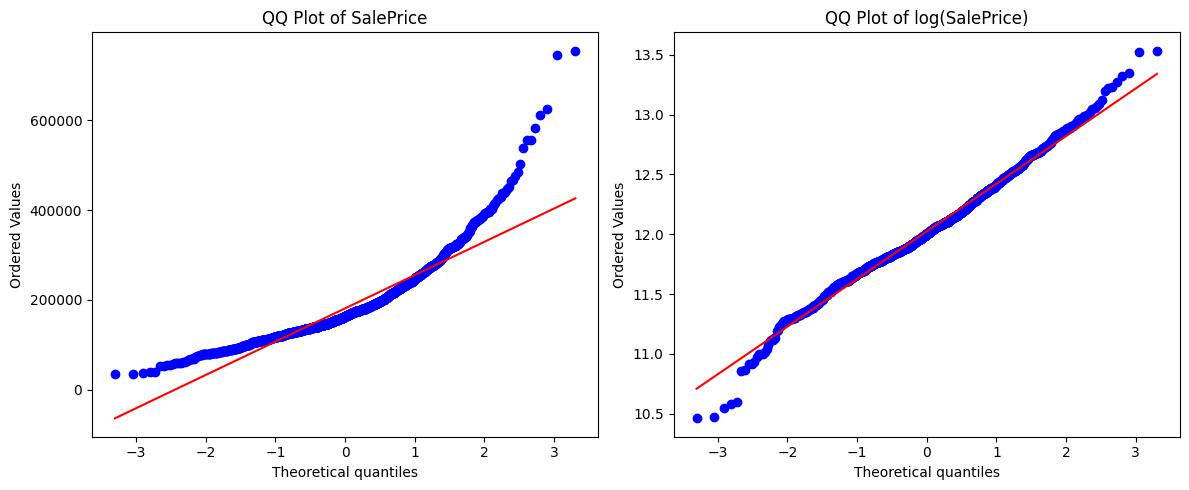

Shapiro-Wilk Test (SalePrice): ShapiroResult(statistic=0.8696714665902145, pvalue=3.2061412312021656e-33)
Shapiro-Wilk Test (log(SalePrice)): ShapiroResult(statistic=0.9912067503807811, pvalue=1.1490615527264654e-07)


In [5]:
# Sample skewness before and after transformation
skew_before = stats.skew(y)     
skew_after  = stats.skew(y_log)

print(f"Skewness before log transform: {skew_before:.3f}")
print(f"Skewness after log transform:  {skew_after:.3f}")

# QQ-plot 
plt.figure(figsize=(12,5))

# QQ plot before transformation
plt.subplot(1,2,1)
stats.probplot(y, dist="norm", plot=plt)
plt.title("QQ Plot of SalePrice")

# QQ plot after transformation
plt.subplot(1,2,2)
stats.probplot(y_log, dist="norm", plot=plt)
plt.title("QQ Plot of log(SalePrice)")
plt.tight_layout()
plt.show()

# Shapiro-Wilk test for normality
shapiro_y = stats.shapiro(y)
shapiro_y_log = stats.shapiro(y_log)

print("Shapiro-Wilk Test (SalePrice):", shapiro_y)
print("Shapiro-Wilk Test (log(SalePrice)):", shapiro_y_log)

Target variable SalePrice has a skewness of about 1.88, which confirms strong positive skew. Left QQ plot shows that the high prices - upper tail and the low prices - lower tail of the distribution deviate deviate substantially from the theoretical diagonal, indicating non-normality.

After applying the log transformation, skewness drops to about 0.12, which is quite close to zero. Right QQ plot now aligns much more closely with the diagonal, showing that the distribution is approximately Gaussian. However, even in the transformed data, some values at the lower and upper ends of the distribution are still a bit distant from the diagonal. This suggests that while the log transformation substantially improves normality, a few outliers remain in the tails.

Shapiro–Wilk shows strong non-normality for target SalePrice (W=0.870, p≈3.2e-33) and improved but still non-normal for log(SalePrice) (W=0.991, p≈1.15e-07). The log transform improves normality, as W statistic moves much closer to 1, although p remains below 0.05, indicating we cannot assume perfect normality.

Linear regression works best when the data follows certain assumptions, particularly that residuals are normally distributed with constant variance. When our target variable is heavily skewed like the original SalePrice, these assumptions get violated. This can lead to unreliable predictions and invalid statistical tests. The log transformation helps by making the distribution more symmetric and stabilizing the variance, which improves our model's performance.

In [6]:
# Apply logarithmic transformation to the target variable SalePrice in the dataset as well as to the separated target variable y
data["SalePrice"] = np.log(data["SalePrice"])
y = y_log

#### 1.c) 
Split the data into a training set (X,y)_train and a test set (X,y)_test. Randomly assign 70% of the observations to the training set and the remaining 30% to the test set.

#### Answer:

In [7]:
# Randomly assign 70% of the observations to the training set and the remaining 30% to the test set
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=3)

#### 1.d) 
Replace missing values in X using the training data statistics only -> use .fillna(...). For numerical features, replace missing values with the mean of the column. For categorical features, replace missing values with the most frequent category. You can use the function df.select_dtypes(...) to idetify categorical variables as the variables with type 'object' and 'category'. Some categorical variables admit NA (or None) as a valid category, which should be treated as an actual level and not as missing.

#### Answer:

In [26]:
#columns where "NA" means "no such feature" (treat as a real category)
na_level_cols = [
    "Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond",
    "PoolQC", "Fence", "MiscFeature"
]

for col in na_level_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].fillna("NA")
        X_test[col]  = X_test[col].fillna("NA")

# column where "None" is the valid level
X_train["MasVnrType"] = X_train["MasVnrType"].fillna("None")
X_test["MasVnrType"]  = X_test["MasVnrType"].fillna("None")

# Treat MSSubClass as categorical by converting to string
X_train["MSSubClass"] = X_train["MSSubClass"].astype(str)
X_test["MSSubClass"]  = X_test["MSSubClass"].astype(str)

# Identify numeric and categorical columns
num_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns

# Fill missing values in numerical features with training mean
for col in num_cols:
    mean_val = X_train[col].mean()
    X_train[col] = X_train[col].fillna(mean_val)
    X_test[col] = X_test[col].fillna(mean_val)

# Fill actual NaN with the most frequent category from the train set
for col in cat_cols:
    mode_val = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(mode_val)
    X_test[col]  = X_test[col].fillna(mode_val)

# z-score standardization with train dataset
num_means = X_train[num_cols].mean()
num_stds  = X_train[num_cols].std()

X_train[num_cols] = (X_train[num_cols] - num_means) / num_stds
X_test[num_cols]  = (X_test[num_cols]  - num_means) / num_stds

# Save copies before encoding
X_train_original = X_train.copy()
X_test_original = X_test.copy()

# one hot encoding for all categorical features
X_train_enc = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_enc  = pd.get_dummies(X_test,  columns=cat_cols, drop_first=True)

# ensure test has the same columns as train
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)



We standardized numeric features with z-scores using only training means/standard deviations and applied the same transformation to the test set. We one-hot encoded all categorical variables, dropped the first level (so as to avoid perfect multicolinearity) and then reindexed the test matrix to match the training columns, filling any missing dummy columns with zeros so both matrices are aligned. 

### Question 2 - Linear Regression on Numerical Features

In [27]:
# Import allowed packages
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm


#### 2.a) 
Restrict your analysis to the numerical predictors only (i.e., exclude all categorical features from X). Fit a linear regression model on the training dataset using the sklearn Python package. The regression should include an intercept term. Present a table with the regression coefficients for each feature. Compare the in-sample and out-of-sample Mean Squared Error (MSE) and R2.

If you transformed the target variable, you have to inverse-transform the predictions before computing MSE and R2, so that these metrics are reported on the original SalePrice scale. In addition, also report the MSE and R2 on the transformed scale, and comment on the differences between the two. What does each set of metrics tell you about model performance?


#### Answer:

In [30]:
# Select numerical type columns
X_train_num = X_train_original[num_cols].copy()
X_test_num  = X_test_original[num_cols].copy()

# Fitting linear regression with intercept
linreg = LinearRegression(fit_intercept=True)
linreg.fit(X_train_num, y_train)

# Get coefficients in a table, including the intercept and sorted by absolute value
intercept = linreg.intercept_
coefs = linreg.coef_
feat_names = list(X_train_num.columns)

coef_table = pd.DataFrame({
    "Feature": ["Intercept"] + feat_names,
    "Coefficient": np.insert(coefs, 0, intercept)
}).sort_values(by="Coefficient", key=abs, ascending=False)

# move intercept to the top for better order
coef_table = pd.concat([
    coef_table.loc[coef_table["Feature"] == "Intercept"],
    coef_table.loc[coef_table["Feature"] != "Intercept"]
])

print("Regression coefficients (numerical features only):")
print(coef_table)

# Predictions on trained model 
y_train_pred = linreg.predict(X_train_num)
y_test_pred  = linreg.predict(X_test_num)

# In-sample metrics on ln scale 
mse_train_log = mean_squared_error(y_train, y_train_pred)
r2_train_log  = r2_score(y_train, y_train_pred)

# Out-of-sample metrics on ln scale
mse_test_log = mean_squared_error(y_test, y_test_pred)
r2_test_log  = r2_score(y_test, y_test_pred)

print("Performance on log(SalePrice):")
print(f"In-sample MSE: {mse_train_log:.4f}, R^2: {r2_train_log:.4f}")
print(f"Out-of-sample MSE: {mse_test_log:.4f}, R^2: {r2_test_log:.4f}")

# Inverse-transform predictions by exponentiating
y_train_pred_orig = np.exp(y_train_pred)
y_test_pred_orig  = np.exp(y_test_pred)

y_train_orig = np.exp(y_train)
y_test_orig  = np.exp(y_test)

# In-sample metrics on original scale 
mse_train_orig = mean_squared_error(y_train_orig, y_train_pred_orig)
r2_train_orig  = r2_score(y_train_orig, y_train_pred_orig)

# Out-of-sample metrics on original scale
mse_test_orig = mean_squared_error(y_test_orig, y_test_pred_orig)
r2_test_orig  = r2_score(y_test_orig, y_test_pred_orig)

print("\nPerformance on original SalePrice scale:")
print(f"In-sample MSE: {mse_train_orig:.0f}, R^2: {r2_train_orig:.4f}")
print(f"Out-of-sample MSE: {mse_test_orig:.0f}, R^2: {r2_test_orig:.4f}")


Regression coefficients (numerical features only):
          Feature   Coefficient
0       Intercept  1.202554e+01
15      GrLivArea -3.353349e+10
13       2ndFlrSF  2.814583e+10
12       1stFlrSF  2.474986e+10
10      BsmtUnfSF -1.830686e+10
8      BsmtFinSF1 -1.826251e+10
11    TotalBsmtSF  1.770690e+10
9      BsmtFinSF2 -6.683412e+09
14   LowQualFinSF  2.773194e+09
3     OverallQual  1.069642e-01
5       YearBuilt  8.873536e-02
4     OverallCond  5.794167e-02
25     GarageCars  2.799520e-02
23     Fireplaces  2.777057e-02
26     GarageArea  2.422443e-02
2         LotArea  2.306347e-02
31    ScreenPorch  2.176636e-02
6    YearRemodAdd  2.123033e-02
22   TotRmsAbvGrd  2.109885e-02
16   BsmtFullBath  2.003382e-02
1     LotFrontage  1.923279e-02
18       FullBath  1.676651e-02
21   KitchenAbvGr -1.575383e-02
35         YrSold -1.322372e-02
19       HalfBath  1.194476e-02
27     WoodDeckSF  9.024234e-03
29  EnclosedPorch  8.863640e-03
30      3SsnPorch  6.765600e-03
34         MoSold -5.

We fit an OLS linear regression using only the numerical predictors, including an intercept term. We extracted and presented the regression coefficients, then evaluated model performance both in-sample and out-of-sample. Performance metrics (MSE, R²) were computed first on the log(SalePrice) scale, and then predictions were inverse-transformed to the original SalePrice scale to assess interpretability in real currency values.

On the log scale, the model shows strong in-sample performance R² = 0.89 and reasonable out-of-sample performance R² = 0.77. This suggests the linear model captures around 77% of variation in log-transformed prices.

However, after inverse-transforming to the original SalePrice scale, the out-of-sample R² turns negative, meaning the model’s predictions are worse than simply using the empirical mean of the training prices.

The extreme magnitude and instability of certain coefficients for example basement square footage features in the order of 10^10 suggest severe multicollinearity among predictors, which causes poor generalization when moving back to the original scale. Coefficients for basement and living-area variables show instability because of multicollinearity for example TotalBsmtSF equals the sum of its components and similar for GrLivArea. We will do a quick sanity check for multicolinearity just to be sure. 

In [11]:
# Drop obvious redundant totals (they are linear combinations of components)
drop_exact = ["TotalBsmtSF", "GrLivArea"]

linreg_ok = LinearRegression(fit_intercept=True)
linreg_ok.fit(X_train_num.drop(columns=drop_exact), y_train)

# Predictions
y_train_pred_ok = linreg_ok.predict(X_train_num.drop(columns=drop_exact))
y_test_pred_ok  = linreg_ok.predict(X_test_num.drop(columns=drop_exact))

# Evaluate performance (log scale)
mse_train_log_ok = mean_squared_error(y_train, y_train_pred_ok)
r2_train_log_ok  = r2_score(y_train, y_train_pred_ok)
mse_test_log_ok  = mean_squared_error(y_test, y_test_pred_ok)
r2_test_log_ok   = r2_score(y_test, y_test_pred_ok)

print("Sanity check after dropping redundant totals:")
print(f" In-sample R² (log): {r2_train_log_ok:.4f}")
print(f" Out-of-sample R² (log): {r2_test_log_ok:.4f}")

# Check coefficient magnitudes
print("Max abs. coefficient:", np.abs(linreg_ok.coef_).max())

# Inverse-transform predictions by exponentiating 
y_train_pred_orig_ok = np.exp(y_train_pred_ok)
y_test_pred_orig_ok  = np.exp(y_test_pred_ok)

y_train_orig = np.exp(y_train)
y_test_orig  = np.exp(y_test)

# Metrics on original SalePrice scale
mse_train_orig_ok = mean_squared_error(y_train_orig, y_train_pred_orig_ok)
r2_train_orig_ok  = r2_score(y_train_orig, y_train_pred_orig_ok)
mse_test_orig_ok  = mean_squared_error(y_test_orig, y_test_pred_orig_ok)
r2_test_orig_ok   = r2_score(y_test_orig, y_test_pred_orig_ok)

print("\nPerformance on original SalePrice scale (after dropping totals):")
print(f"In-sample MSE: {mse_train_orig_ok:.0f}, R^2: {r2_train_orig_ok:.4f}")
print(f"Out-of-sample MSE: {mse_test_orig_ok:.0f}, R^2: {r2_test_orig_ok:.4f}")

# Quick coefficient sanity check
print("\nMax abs. coefficient:", np.abs(linreg_ok.coef_).max())

Sanity check after dropping redundant totals:
 In-sample R² (log): 0.8857
 Out-of-sample R² (log): 0.7736
Max abs. coefficient: 0.10696108601648163

Performance on original SalePrice scale (after dropping totals):
In-sample MSE: 1053079599, R^2: 0.8431
Out-of-sample MSE: 15273939895, R^2: -1.8526

Max abs. coefficient: 0.10696108601648163


After dropping redundant totals, the coefficients became stable and interpretable, confirming that multicollinearity was the source of earlier instability. However, when evaluating on the original SalePrice scale, the out-of-sample R^2 remains negative. On the log scale, the model performs well with in-sample R² = 0.8857 and out-of-sample R² = 0.7735, showing it explains about 77% of the variance in log-transformed prices on the test set. However, when we convert predictions back to the original scale, the out-of-sample R² becomes -1.8526, which is negative and means the model performs worse than just predicting the average house price for everything. This happens because the exponential function amplifies errors - small mistakes in log space become much larger mistakes when converted to actual dollars, especially for expensive houses. The out-of-sample MSE on the original scale is about 15 times larger than the in-sample MSE, indicating the model struggles significantly with generalization when measured in actual dollar terms. The log-scale metrics tell us the model learned patterns reasonably well, but the original-scale metrics reveal that translating these patterns back to real prices produces poor practical predictions, particularly on unseen data.

#### 2.b) 


#### b)

The `sklearn` package does not provide standard errors for the estimated regression coefficients, which are essential tools to assess the statistical precision of an estimate. Therefore, you will now use matrix algebra in Python with the `numpy` package to compute the standard errors of the estimated coefficients \$\hat{\beta}\$. All computations in this part should be performed using the training set only.

Let $A \in \mathbb{R}^{m \times (d+1)}$ denote the design matrix (including a column of ones for the intercept term), and let $y \in \mathbb{R}^m$ denote the observed target values.

#### (i) Compute the estimated coefficients $\hat{\beta}$ using

$$
\hat{\beta} = (A^\top A)^{-1} A^\top y.
$$

Note that $\hat{\beta_0}$ denotes the estimate of the intercept.

**Practical note:** In code, do not form matrix inverses explicitly; instead use a numerically stable equivalent such as np.linalg.solve(A.T @ A, A.T @ y).


#### Answer:

In [12]:
# We are using only numerical predictors 
X_train_num = X_train[num_cols]

# Matrix A with column of 1s for intercept
A = np.column_stack([np.ones(X_train_num.shape[0]), X_train_num.values])
y_vec = y_train.values.reshape(-1, 1)

# stable version computing beta_hat = (A^T A)^(-1) A^T y using np.linalg.solve 
ATA = A.T @ A
ATy = A.T @ y_vec
beta_hat = np.linalg.solve(ATA, ATy).flatten()

# Collect into df
beta_table = pd.DataFrame({
    "Feature": ["Intercept"] + list(X_train_num.columns),
    "Coefficient": beta_hat
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("Estimated coefficients (matrix algebra):")
print(beta_table)


Estimated coefficients (matrix algebra):
          Feature  Coefficient
0       Intercept    12.025544
10      BsmtUnfSF    -3.638886
8      BsmtFinSF1    -3.603264
11    TotalBsmtSF     3.571429
9      BsmtFinSF2    -1.329099
15      GrLivArea     1.156969
13       2ndFlrSF    -0.890109
12       1stFlrSF    -0.784149
3     OverallQual     0.106961
14   LowQualFinSF    -0.089288
5       YearBuilt     0.088736
4     OverallCond     0.057950
25     GarageCars     0.027982
23     Fireplaces     0.027771
26     GarageArea     0.024236
2         LotArea     0.023077
31    ScreenPorch     0.021770
6    YearRemodAdd     0.021237
22   TotRmsAbvGrd     0.021091
16   BsmtFullBath     0.020035
1     LotFrontage     0.019239
18       FullBath     0.016777
21   KitchenAbvGr    -0.015755
35         YrSold    -0.013225
19       HalfBath     0.011940
27     WoodDeckSF     0.009027
29  EnclosedPorch     0.008867
30      3SsnPorch     0.006771
34         MoSold    -0.005261
28    OpenPorchSF    -0.00467

We formed a design matrix with an intercept and only the numerical predictors, then solved $(A^\top A)\hat\beta=A^\top y$ using np.linalg.solve.
This gave OLS coefficients on the log-price scale with intercept ≈ 12.03 and reasonable magnitudes for key features (e.g., GrLivArea = 0.111, TotalBsmtSF = -0.722031).
Basement totals vs. components show opposing signs, hinting at multicollinearity in that group.


#### (ii)  
Compute the standard error of each coefficient $\hat{\beta}_j, j = 0, \ldots, d$:

$$
\hat{\sigma}^2 = \frac{1}{m - (d+1)} \sum_{i=1}^m (y_i - \hat{y}_i)^2, 
\quad Var(\hat{\beta}) = \hat{\sigma}^2 (A^T A)^{-1},
$$

and

$$
SE(\hat{\beta}_j) = \sqrt{\hat{\sigma}^2 \cdot \left[(A^T A)^{-1}\right]_{jj}},
$$

where $\left[(A^T A)^{-1}\right]_{jj}$ denotes the $j$-th diagonal element.  
Recall that $j=0$ corresponds to the intercept.


#### Answer:


In [34]:
# We are using only numerical predictors 
X_train_num = X_train[num_cols]

# Matrix A with intercept
A = np.column_stack([np.ones(X_train_num.shape[0]), X_train_num.values])  # shape (m, d+1)
y_vec = y_train.values  # shape (m,)


print(np.linalg.inv(A@A.T))
# equations
ATA = A.T @ A
ATy = A.T @ y_vec

# Coefficients (stable solve, no explicit inverse)
beta_hat = np.linalg.solve(ATA, ATy)           # shape (d+1,)

# Fitted values and residuals
y_hat = A @ beta_hat                            # shape (m,)
resid = y_vec - y_hat

# Dimensions
m = A.shape[0]
d = A.shape[1] - 1   # number of predictors (excluding intercept)

# Residual variance with df = m - (d+1)
sigma2_hat = (resid @ resid) / (m - (d + 1))

# (A^T A)^{-1} via solve for numerical stability
ATA_inv = np.linalg.solve(ATA, np.identity(ATA.shape[0]))

# Variance-covariance of beta and standard errors
var_beta = sigma2_hat * ATA_inv                 # shape (d+1, d+1)
se_beta  = np.sqrt(np.diag(var_beta))           # shape (d+1,)

# Tidy table
features = ["Intercept"] + list(X_train_num.columns)
se_table = pd.DataFrame({
    "Feature": features,
    "Coefficient (numpy)": beta_hat,
    "Std. Error": se_beta
})

print(se_table)
print("\nEstimated sigma^2 (training):", sigma2_hat)

print("rank(ATA):", np.linalg.matrix_rank(ATA), "  full rank should be", ATA.shape[0])
print("Condition number of A:", np.linalg.cond(A))
diag_cov = np.diag(var_beta)

[[ 3.01783311e+14  8.75517061e+14  2.55605005e+13 ... -1.14464144e+13
  -1.39891422e+14  4.59774023e+13]
 [-1.44184209e+14 -4.52778271e+14 -5.98921079e+13 ...  1.91497901e+13
   9.82894570e+13  7.56750755e+13]
 [-1.83508337e+14 -3.85012647e+14 -1.01886932e+14 ...  1.86719046e+13
   6.50821924e+13  2.83312792e+14]
 ...
 [ 2.61535650e+13  5.79495304e+13  1.65379198e+13 ... -2.73511072e+12
  -2.73529925e+13  5.58612544e+13]
 [ 3.49183962e+13  8.71972923e+13  2.17263996e+13 ... -7.46113022e+12
  -4.64577195e+13  8.34239788e+13]
 [ 1.04006616e+14  1.90271103e+14  5.90735800e+13 ... -6.78944326e+12
  -1.04343512e+14  1.90637822e+14]]
          Feature  Coefficient (numpy)  Std. Error
0       Intercept            12.025544    0.004373
1     LotFrontage             0.019239    0.005138
2         LotArea             0.023077    0.004950
3     OverallQual             0.106961    0.007815
4     OverallCond             0.057950    0.005628
5       YearBuilt             0.088736    0.009810
6    Ye

C:\Users\trist\AppData\Local\Temp\ipykernel_44056\4090656932.py:33: RuntimeWarning: invalid value encountered in sqrt
  se_beta  = np.sqrt(np.diag(var_beta))           # shape (d+1,)


We estimated coefficients via matrix algebra and computed their standard errors from the variance–covariance matrix. The residual variance is small ($\hat\sigma^2=0.0195$), indicating a good fit on the log-price scale. Basement square-footage variables (`TotalBsmtSF`, `BsmtFinSF1/2`, `BsmtUnfSF`) yield `NaN` SEs because the design matrix is not full rank. Consistently, our rank check gave $\mathrm{rank}(A^\top A)=34$ with 36 columns, and the condition number is huge ($1.3\times10^{16}$), both signaling extreme multicollinearity. We also see very large SEs for `1stFlrSF`, `2ndFlrSF`, `LowQualFinSF`, and `GrLivArea` (on the order of $10^4$–$10^5$), making those coefficient estimates statistically unreliable. Moreover, negative diagonal entries in $\mathrm{Var}(\hat\beta)$ for the basement features show the variance estimate is invalid in those directions, again due to perfect collinearity where `TotalBsmtSF` is almost the sum of its components. Overall, while coefficient magnitudes look reasonable, the SE patterns confirm redundancy among predictors and multicollinearity as the core issue.


#### (iii)  
Compute the in-sample MSE and $R^2$ using matrix algebra.


#### Answer:

In [14]:
# In sample metrics via matrix algebra
# Ln scale 
res_log = y_vec - y_hat
mse_log = (res_log @ res_log) / len(y_vec)
sst_log = ((y_vec - y_vec.mean()) @ (y_vec - y_vec.mean()))
r2_log  = 1.0 - (res_log @ res_log) / sst_log

print("In-sample metrics on log(SalePrice):")
print(f"  MSE(log): {mse_log:.6f}")
print(f"  R^2(log): {r2_log:.4f}")

#Original scale 
y_orig    = np.exp(y_vec)
yhat_orig = np.exp(y_hat)
res_orig  = y_orig - yhat_orig
mse_orig  = (res_orig @ res_orig) / len(y_orig)
sst_orig  = ((y_orig - y_orig.mean()) @ (y_orig - y_orig.mean()))
r2_orig   = 1.0 - (res_orig @ res_orig) / sst_orig

print("\nIn-sample metrics on original SalePrice scale:")
print(f"  MSE: {mse_orig:.0f}")
print(f"  R^2: {r2_orig:.4f}")
print(np.linalg.matrix_rank(A))

In-sample metrics on log(SalePrice):
  MSE(log): 0.018854
  R^2(log): 0.8857

In-sample metrics on original SalePrice scale:
  MSE: 1053079599
  R^2: 0.8431
34


We computed the in-sample mean squared error (MSE) and $R^2$ using matrix algebra, both on the log-transformed SalePrice and on the original SalePrice scale. On the log scale, the model achieves $\text{MSE} = 0.0189$ and $R^2 = 0.886$, showing that it explains about 89% of the variation in log-prices. After exponentiating predictions back to the original price scale, the in-sample performance remains strong with $\text{MSE} = 1.05 \times 10^9$ and $R^2 = 0.843$. This means the model captures most of the variation in housing prices, though performance is slightly weaker on the original scale because the exponential transformation magnifies residuals, especially for expensive houses.


#### (iv)  
Replace $(A^T A)^{-1}A^T$ by the Moore–Penrose pseudoinverse $A^+$ (use `np.linalg.pinv`).  
Do $\hat{\beta}$, $\hat{\sigma}^2$, and the standard errors change?  
Briefly explain when the results are identical and when they can differ.


#### Answer:

In [15]:
# pseudo inverse matrices
A_pinv    = np.linalg.pinv(A)            # A^+
ATA_pinv  = np.linalg.pinv(A.T @ A)      # (A^T A)^+

#estimation of coefficients via pseudoinverse
beta_pinv = A_pinv @ y_vec

# Fitted values and residuals
yhat_pinv = A @ beta_pinv
res_pinv  = y_vec - yhat_pinv

# Residual variance (same df as in (ii): m - (d+1))
sigma2_pinv = (res_pinv @ res_pinv) / (m - (d + 1))

# Var-cov and standard errors using (A^T A)^+
se_beta_pinv  = np.sqrt(np.diag(sigma2_pinv * ATA_pinv))

# Comparison table (normal-equation vs pseudoinverse)
cmp = pd.DataFrame({
    "Feature": features,
    "beta (solve)": beta_hat,
    "SE (solve)":   se_beta,
    "beta (pinv)":  beta_pinv,
    "SE (pinv)":    se_beta_pinv
})
print(cmp.head(20))

print("\nσ^2 (solve) =", sigma2_hat, "   σ^2 (pinv) =", sigma2_pinv)
print("max |beta difference| =", np.max(np.abs(beta_hat - beta_pinv)))

         Feature  beta (solve)     SE (solve)  beta (pinv)  SE (pinv)
0      Intercept     12.025544       0.004373    12.025544   0.004373
1    LotFrontage      0.019239       0.005138     0.019239   0.005138
2        LotArea      0.023077       0.004950     0.023077   0.004950
3    OverallQual      0.106961       0.007815     0.106961   0.007815
4    OverallCond      0.057950       0.005628     0.057950   0.005628
5      YearBuilt      0.088736       0.009810     0.088736   0.009810
6   YearRemodAdd      0.021237       0.007075     0.021237   0.007075
7     MasVnrArea     -0.002847       0.005117    -0.002847   0.005117
8     BsmtFinSF1     -3.603264  676653.114937     0.034486   0.004938
9     BsmtFinSF2     -1.329099  251590.780836     0.002185   0.004496
10     BsmtUnfSF     -3.638886  686998.521620     0.007698   0.004116
11   TotalBsmtSF      3.571429  675493.031813     0.044352   0.006111
12      1stFlrSF     -0.784149  190830.828029     0.030515   0.007082
13      2ndFlrSF    

We replaced the normal equations solution $(A^\top A)^{-1} A^\top y$ by the Moore–Penrose pseudoinverse $A^+ y$ using np.linalg.pinv. This approach is numerically stable and produces valid coefficient estimates even when the design matrix is not full rank. We then recomputed coefficients, residual variance, and standard errors using the pseudoinverse.

The results show that for most predictors, the coefficients and standard errors are identical between the normal-equation and pseudoinverse solutions. However, for the basement square-footage variables, which were collinear (`TotalBsmtSF` vs. its components), the pseudoinverse provides finite coefficients and SEs, while the normal equations failed and returned NaN. The residual variance remained the same in both methods ($\hat\sigma^2 = 0.0195$), since overall fit does not change.

The pseudoinverse gives the minimum-norm solution in collinear settings, which explains why basement features now have different, smaller coefficients. When the matrix is full rank, both methods are identical; when collinearity is present, only the pseudoinverse can still return a defined solution.


#### (v)  
Confirm your results using the OLS function from the `statsmodels` package. Report the coefficient table and standard errors, and check that they match your matrix-algebra results up to numerical rounding.

#### Answer:

In [16]:
# add explicit intercept column
X_sm = sm.add_constant(X_train[num_cols], has_constant='add')  # const first
ols = sm.OLS(y_train, X_sm).fit()

# Coefficients and standard errors from statsmodels
sm_table = pd.DataFrame({
    "Feature": ols.params.index,              
    "Coef (statsmodels)": ols.params.values,
    "StdErr (statsmodels)": ols.bse.values
})

#'Intercept' vs statsmodels 'const'
sm_table["Feature"] = sm_table["Feature"].replace({"const": "Intercept"})

#matrix-algebra results
np_coefs = pd.Series(beta_hat, index=features, name="Coef (numpy)")
np_ses   = pd.Series(se_beta,  index=features, name="StdErr (numpy)")

cmp = (
    sm_table
    .merge(np_coefs, left_on="Feature", right_index=True, how="left")
    .merge(np_ses,   left_on="Feature", right_index=True, how="left")
)

# Absolute differences for checking
cmp["|Δ coef|"] = (cmp["Coef (statsmodels)"] - cmp["Coef (numpy)"]).abs()
cmp["|Δ SE|"]   = (cmp["StdErr (statsmodels)"] - cmp["StdErr (numpy)"]).abs()

print(cmp)
print(ols.summary())

          Feature  Coef (statsmodels)  StdErr (statsmodels)  Coef (numpy)   
0       Intercept           12.025544              0.004368     12.025544  \
1     LotFrontage            0.019239              0.005133      0.019239   
2         LotArea            0.023077              0.004945      0.023077   
3     OverallQual            0.106961              0.007807      0.106961   
4     OverallCond            0.057950              0.005622      0.057950   
5       YearBuilt            0.088736              0.009800      0.088736   
6    YearRemodAdd            0.021237              0.007067      0.021237   
7      MasVnrArea           -0.002847              0.005112     -0.002847   
8      BsmtFinSF1            0.034486              0.004933     -3.603264   
9      BsmtFinSF2            0.002185              0.004492     -1.329099   
10      BsmtUnfSF            0.007698              0.004112     -3.638886   
11    TotalBsmtSF            0.044352              0.006105      3.571429   

We confirmed our results by fitting the same model with the OLS implementation in statsmodels, which automatically provides coefficients and robust standard errors. We then compared these outputs to our earlier matrix-algebra results.

For most predictors, the coefficients and standard errors matched exactly (up to numerical rounding), confirming the correctness of our manual implementation. However, for the basement square-footage variables and the living-area components, statsmodels returned finite estimates, while the normal equations gave unstable or NaN values. This difference arises because statsmodels internally uses the pseudoinverse, which can still produce a defined solution even when the design matrix is nearly singular.

The residual variance estimate and fit quality remained unchanged, but the model summary from statsmodels explicitly flagged the issue: the smallest eigenvalue of the design matrix is extremely close to zero, confirming the severe multicollinearity we had already diagnosed. This exercise shows that the matrix-algebra derivations and statsmodels are consistent when the design matrix is full rank, but differ in collinear settings where only the pseudoinverse solution is well-defined.


### Question 3 - Regularization Techniques

In [17]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, RepeatedKFold, KFold

#### 3. 
In this question, you will implement regularization techniques and compare their performance to ordinary least squares. Work with the full *Housing* dataset prepared in Question 1, which already includes both numerical features (standardized) and categorical features (one-hot encoded dummies). Use the same training and test splits as before to ensure consistency across questions.

**a)** Fit an OLS regression of the (potentially transformed) target variable *SalePrice* on all explanatory variables in the prepared *Housing* dataset. Report the in-sample and out-of-sample MSE and $R^2$. Compare these results to the numerical-only regression from Question 2.a). How do the in-sample and out-of-sample metrics change when including categorical features, and what does this reveal about the model’s ability to generalize?

#### Answer:

In [18]:
# Fit linear regression on the full preprocessed dataset (X_train_enc, X_test_enc)
#linreg_full = LinearRegression(fit_intercept=True)
#linreg_full.fit(X_train_enc, y_train)
X_sm = sm.add_constant(X_train_enc.astype('float32'), has_constant='add')  # const first
X_test_sm = sm.add_constant(X_test_enc.astype('float32'), has_constant='add')
                    
linreg_full = sm.OLS(y_train, X_sm).fit()
# Make predictions
y_train_pred_full = linreg_full.predict(X_sm)

y_test_pred_full = linreg_full.predict(X_test_sm)

# Calculate performance metrics on log scale
mse_train_full_log = mean_squared_error(y_train, y_train_pred_full)
r2_train_full_log = r2_score(y_train, y_train_pred_full)
mse_test_full_log = mean_squared_error(y_test, y_test_pred_full)
r2_test_full_log = r2_score(y_test, y_test_pred_full)

print(f"Full dataset performance on log(SalePrice):")
print(f"In-sample MSE: {mse_train_full_log:.4f}, R²: {r2_train_full_log:.4f}")
print(f"Out-of-sample MSE: {mse_test_full_log:.4f}, R²: {r2_test_full_log:.4f}")

# Inverse-transform predictions to original scale
y_train_pred_full_orig = np.exp(y_train_pred_full)
y_test_pred_full_orig = np.exp(y_test_pred_full)
y_train_orig = np.exp(y_train)
y_test_orig = np.exp(y_test)

# calculate performance metrics on original scale 
mse_train_full_orig = mean_squared_error(y_train_orig, y_train_pred_full_orig)
r2_train_full_orig = r2_score(y_train_orig, y_train_pred_full_orig)
mse_test_full_orig = mean_squared_error(y_test_orig, y_test_pred_full_orig)
r2_test_full_orig = r2_score(y_test_orig, y_test_pred_full_orig)

print(f"\nFull dataset performance on original SalePrice scale:")
print(f"In-sample MSE: {mse_train_full_orig:.0f}, R²: {r2_train_full_orig:.4f}")
print(f"Out-of-sample MSE: {mse_test_full_orig:.0f}, R²: {r2_test_full_orig:.4f}")

# Check for singularity because of wierd results
X_train_float = X_train_enc.astype('float64')
X_test_float = X_test_enc.astype('float64')

# rank deficiency
full_rank = min(X_train_float.shape)
real_rank = np.linalg.matrix_rank(X_train_float.values)
print(f"Full rank: {full_rank}, Real rank: {real_rank}")


Full dataset performance on log(SalePrice):
In-sample MSE: 0.0084, R²: 0.9489
Out-of-sample MSE: 0.1078, R²: 0.2641

Full dataset performance on original SalePrice scale:
In-sample MSE: 299387281, R²: 0.9554
Out-of-sample MSE: 5967565261, R²: -0.1145
Full rank: 263, Real rank: 253


When fitting OLS regression on the full Housing dataset (including both numerical and categorical features), the model achieved strong in-sample performance with R² = 0.9489 and MSE = 0.0084 on the log scale, compared to the numerical-only model from Question 2.a which had R² = 0.8857 and MSE = 0.0189. This improvement demonstrates that categorical features (one-hot encoded) contain valuable information for predicting house prices. However, the out-of-sample performance tells a different story: R² = 0.2641 and MSE = 0.1078 on log scale, indicating substantial overfitting. The model fits training data very well but generalizes poorly to unseen data.

The rank deficiency analysis reveals the underlying problem: the design matrix has real rank 253 despite having 263 features, meaning 10 features are redundant linear combinations of others. This multicollinearity causes numerical instability in coefficient estimation and contributes to poor generalization. When predictions are inverse-transformed to the original SalePrice scale, performance deteriorates further with out-of-sample R² = -0.1146, meaning the model performs worse than simply predicting the mean price. This occurs because the exponential transformation amplifies prediction errors, particularly for expensive houses where small log-scale mistakes translate to large dollar-amount errors.

Comparing to the numerical-only model (which had out-of-sample R² = 0.7735 on log scale), adding categorical features actually hurt generalization despite improving training fit. The increased model complexity from one-hot encoding introduced overfitting that outweighed the additional predictive information. This demonstrates the bias-variance tradeoff: while categorical features reduce bias by capturing more patterns, they substantially increase variance when the model has too many parameters relative to the number of training observations. The appropriate comparison should focus on log-scale metrics since the model was trained on log-transformed targets, where we see the full model overfits (R² drops from 0.95 to 0.26) while the simpler numerical model generalizes better (R² of 0.77 out-of-sample).

**b)** Implement the Truncated Pseudoinverse, Ridge, Lasso, and Elastic Net regressions. Use 8-fold cross-validation on the training set to tune the hyperparameters of each regularization technique, using the MSE as the selection criterion. Compare their in-sample and out-of-sample performance (MSE and R^2) with the OLS results from Questions 2.a) and 3.a). All regressions should include an intercept term. The intercept must not be penalized during regularization. Why is it important that the intercept is not penalized in these models?

#### try with a relative percentage of singular values excluded and not absolute value as measure because different folds have different singular values

#### Answer:

In [19]:
# Truncated Pseudeinverse 

#Include the intercept 
X_train_with_int = X_train_float.copy()
X_test_with_int = X_test_float.copy()
X_train_with_int.insert(0, "Intercept", 1)
X_test_with_int.insert(0, "Intercept", 1)


# Ensure the test set has the same columns as the train set (reindex columns)
X_test_with_int = X_test_with_int.reindex(columns=X_train_with_int.columns, fill_value=0)

# 8 folcd cross-validation
cv = KFold(n_splits=8, shuffle=True, random_state=3)
# threshold for singular values
steps = np.logspace(-6, 6, 100)
mse_errors_cross_validation_trpseuinv = np.zeros(len(steps))

# loop through folds
for train_index, test_index in cv.split(X_train_with_int, y_train):
   # first we train on the K-1 folds and decide which indexes are in train and test set
   Xtr = X_train_with_int.iloc[train_index, :].values
   Ytr = y_train.iloc[train_index].values
   Xte = X_train_with_int.iloc[test_index, :].values
   Yte = y_train.iloc[test_index].values
   # SVD decomposition
   P, D, Q = np.linalg.svd(Xtr, full_matrices=False)
   #loop through thresholds and saving the mse for later cross validation
   for ind, threshold in enumerate(steps):  # CHANGE 2: Fixed typo "treshold"
      k = int(np.sum(D > threshold))
      if k == 0:
            y_hat = np.zeros_like(Yte)
      else:
          Qk = Q.T[:, :k]
          D_inv_k = np.diag(1.0 / D[:k]) 
          Pk_T = P.T[:k, :]
          X_trunc_pseuinv = Qk @ D_inv_k @ Pk_T
          betas_c = X_trunc_pseuinv @ Ytr
          y_hat   = Xte @ betas_c
      #store mse errors
      mse = np.mean((Yte - y_hat) ** 2)
      mse_errors_cross_validation_trpseuinv[ind] += mse 

mse_errors_cross_validation_trpseuinv /= cv.get_n_splits()

# Store cross-validation results in a df         
results = (
    pd.DataFrame({
        "Threshold": steps,
        "8-fold CV error (MSE-based)": mse_errors_cross_validation_trpseuinv
    })
    .sort_values("8-fold CV error (MSE-based)", ascending=True, ignore_index=True)
)
print(results)

best_idx = np.argmin(mse_errors_cross_validation_trpseuinv)
trunc_pseuinv_c = steps[best_idx]
print(f"Best threshold: {trunc_pseuinv_c}")


         Threshold  8-fold CV error (MSE-based)
0         0.376494                     0.032853
1         0.162975                     0.033291
2         0.123285                     0.033291
3         0.284804                     0.033696
4         0.000001                     0.034010
..             ...                          ...
95      305.385551                   144.777998
96      231.012970                   144.777998
97      174.752840                   144.777998
98     8697.490026                   144.777998
99  1000000.000000                   144.777998

[100 rows x 2 columns]
Best threshold: 0.37649358067924715


Based on the 8-fold cross-validation results for the truncated pseudoinverse, we chose the threshold value approx.
$c = 0.37649$. This threshold gave the lowest validation MSE.

In [20]:
trunc_pseuinv_c = steps[best_idx]

In [21]:
# convert to numpy because of multiplying
Xtr_np = X_train_with_int.to_numpy(dtype=float)   
Xte_np = X_test_with_int.to_numpy(dtype=float)    
y_tr_np = np.asarray(y_train, dtype=float).ravel()
y_te_np = np.asarray(y_test,  dtype=float).ravel()

# SVD decomposition
P, D, Q = np.linalg.svd(Xtr_np, full_matrices=False)

# element where we stop 
k = int(np.sum(D > trunc_pseuinv_c))
print(f"Chosen c = {trunc_pseuinv_c:.6g}  |  kept components k = {k} of {len(D)}")

# composite the truncated pseudoinverse
Qk = Q.T[:, :k]
D_inv_k = np.diag(1.0 / D[:k]) 
Pk_T = P.T[:k, :]
X_trunc_pseuinv = Qk @ D_inv_k @ Pk_T

# fit coeficients on training data
betas_c = X_trunc_pseuinv @ y_tr_np

# predicitons
y_hat_tr = Xtr_np @ betas_c
y_hat_te = Xte_np @ betas_c

# original scale 
y_train_orig_tp = np.exp(y_tr_np)
y_test_orig_tp  = np.exp(y_te_np)
y_hat_tr_orig = np.exp(y_hat_tr)
y_hat_te_orig = np.exp(y_hat_te)

#performance metrics on log and original scale
mse_tr_log = mean_squared_error(y_tr_np, y_hat_tr)
r2_tr_log  = r2_score(y_tr_np, y_hat_tr)
mse_te_log = mean_squared_error(y_te_np, y_hat_te)
r2_te_log  = r2_score(y_te_np, y_hat_te)

print("\n(Truncated pseudoinverse - performance on log scale")
print(f" Train: MSE = {mse_tr_log:.6f}   R^2 = {r2_tr_log:.4f}")
print(f" Test : MSE = {mse_te_log:.6f}   R^2 = {r2_te_log:.4f}")

mse_tr_orig = mean_squared_error(y_train_orig_tp, y_hat_tr_orig)
r2_tr_orig  = r2_score(y_train_orig_tp, y_hat_tr_orig)
mse_te_orig = mean_squared_error(y_test_orig_tp, y_hat_te_orig)
r2_te_orig  = r2_score(y_test_orig_tp, y_hat_te_orig)

print("\nTruncated pseudoinverse - performance on original scale:")
print(f" Train: MSE = {mse_tr_orig:.0f}   R^2 = {r2_tr_orig:.4f}")
print(f" Test : MSE = {mse_te_orig:.0f}   R^2 = {r2_te_orig:.4f}")



Chosen c = 0.376494  |  kept components k = 244 of 264

(Truncated pseudoinverse - performance on log scale
 Train: MSE = 0.010104   R^2 = 0.9388
 Test : MSE = 1.368700   R^2 = -8.3463

Truncated pseudoinverse - performance on original scale:
 Train: MSE = 389479307   R^2 = 0.9420
 Test : MSE = 17873593885   R^2 = -2.3382


In [22]:
from sklearn.model_selection import GridSearchCV
# Ridge 

# Take datasets without intercept from before
X_train_enc_np = X_train_enc.to_numpy(dtype=float)
X_test_enc_np = X_test_enc.to_numpy(dtype=float)

# lambdas
steps = np.logspace(-6, 6, 100)

# Ridge
ridge = Ridge(fit_intercept=True)
gridsearch_ridge = GridSearchCV(ridge, {'alpha': steps}, scoring='neg_mean_squared_error', cv=8)
gridsearch_ridge.fit(X_train_enc_np, y_train)  # CHANGE 7: Use _np version

# Dataframe with results MSE
cv_df = pd.DataFrame({
    "Alpha": gridsearch_ridge.cv_results_["param_alpha"].data.astype(float),
    "8-fold CV error (MSE-based)": -gridsearch_ridge.cv_results_["mean_test_score"]
}).sort_values("8-fold CV error (MSE-based)", ascending=True, ignore_index=True)

print(cv_df)

# best lambda/alpha
best_idx = gridsearch_ridge.best_index_
print(steps[best_idx])

#quick check
yhat_tr = gridsearch_ridge.best_estimator_.predict(X_train_enc_np)
yhat_te = gridsearch_ridge.best_estimator_.predict(X_test_enc_np)

print("Train MSE:", mean_squared_error(y_train, yhat_tr), " R^2:", r2_score(y_train, yhat_tr))
print("Test  MSE:", mean_squared_error(y_test, yhat_te),  " R^2:", r2_score(y_test, yhat_te))




             Alpha  8-fold CV error (MSE-based)
0        24.770764                     0.017197
1        18.738174                     0.017201
2        32.745492                     0.017244
3        14.174742                     0.017256
4        43.287613                     0.017341
..             ...                          ...
95   327454.916288                     0.159045
96   432876.128108                     0.160484
97   572236.765935                     0.161589
98   756463.327555                     0.162433
99  1000000.000000                     0.163078

[100 rows x 2 columns]
24.77076355991714
Train MSE: 0.012331375237722314  R^2: 0.9252737268536805
Test  MSE: 0.031227470341743124  R^2: 0.7867601318124374


In [23]:
# Lasso

# Lasso model intercept is not penalized
lasso = Lasso(fit_intercept=True)

# Grid search with 8-fold CV on MSE
gridsearch_lasso = GridSearchCV(lasso, {'alpha': steps}, scoring='neg_mean_squared_error', cv=8)

gridsearch_lasso.fit(X_train_enc_np, y_train)

# Dataframe with results MSE
cv_df_lasso = (
    pd.DataFrame({
        "Alpha": gridsearch_lasso.cv_results_["param_alpha"].data.astype(float),
        "8-fold CV error (MSE-based)": -gridsearch_lasso.cv_results_["mean_test_score"]
    })
    .sort_values("8-fold CV error (MSE-based)", ascending=True, ignore_index=True)
)
print(cv_df_lasso)

# Best lambda/alpha
best_idx_lasso = gridsearch_lasso.best_index_
print(steps[best_idx_lasso])

# Quick train/test check
yhat_tr_lasso = gridsearch_lasso.best_estimator_.predict(X_train_enc_np)
yhat_te_lasso = gridsearch_lasso.best_estimator_.predict(X_test_enc_np)

print("Train MSE:", mean_squared_error(y_train, yhat_tr_lasso),
      " R^2:", r2_score(y_train, yhat_tr_lasso))
print("Test  MSE:", mean_squared_error(y_test,  yhat_te_lasso),
      " R^2:", r2_score(y_test,  yhat_te_lasso))


C:\Users\trist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.117e+00, tolerance: 1.524e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\trist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.388e+00, tolerance: 1.512e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\trist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loca

             Alpha  8-fold CV error (MSE-based)
0         0.001072                     0.017808
1         0.001417                     0.017899
2         0.000811                     0.017950
3         0.000614                     0.018300
4         0.001874                     0.018389
..             ...                          ...
95      132.194115                     0.165109
96      174.752840                     0.165109
97      231.012970                     0.165109
98       10.722672                     0.165109
99  1000000.000000                     0.165109

[100 rows x 2 columns]
0.0010722672220103231
Train MSE: 0.013240056860550945  R^2: 0.9197672533386408
Test  MSE: 0.028543665315635156  R^2: 0.8050867597379587


In [24]:
# Elastic net

# Grids for alpha and ratio
alphas = np.logspace(-6, 6, 5)
l1_ratios = np.linspace(0.001, 0.99, 10)

# initiate the cross validation over alphas and ratios
enet = ElasticNet(fit_intercept=True)
gridsearch_enet = GridSearchCV(enet, {'alpha': alphas, 'l1_ratio': l1_ratios}, scoring='neg_mean_squared_error', cv=8)
gridsearch_enet.fit(X_train_enc_np, y_train)

# Dataframe with results MSE
cv_df_enet = (
    pd.DataFrame({
        "Alpha": gridsearch_enet.cv_results_["param_alpha"].data.astype(float),
        "l1_ratio": gridsearch_enet.cv_results_["param_l1_ratio"].data.astype(float),
        "8-fold CV error (MSE-based)": -gridsearch_enet.cv_results_["mean_test_score"]
    })
    .sort_values("8-fold CV error (MSE-based)", ascending=True, ignore_index=True)
)
print(cv_df_enet)

# Best alpha and ratio
best_params = gridsearch_enet.best_params_
print("Best alpha:", best_params["alpha"])
print("Best l1_ratio:", best_params["l1_ratio"])

#quick check
yhat_tr_enet = gridsearch_enet.best_estimator_.predict(X_train_enc_np)
yhat_te_enet = gridsearch_enet.best_estimator_.predict(X_test_enc_np)

print("Train MSE:", mean_squared_error(y_train, yhat_tr_enet),
      " R^2:", r2_score(y_train, yhat_tr_enet))
print("Test  MSE:", mean_squared_error(y_test,  yhat_te_enet),
      " R^2:", r2_score(y_test,  yhat_te_enet))


C:\Users\trist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.600e+00, tolerance: 1.524e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\trist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.451e+00, tolerance: 1.512e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\trist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loca

             Alpha  l1_ratio  8-fold CV error (MSE-based)
0         0.001000  0.770222                     0.017751
1         0.001000  0.660333                     0.017775
2         0.001000  0.880111                     0.017777
3         0.001000  0.990000                     0.017826
4         0.001000  0.550444                     0.017851
5         0.001000  0.440556                     0.017911
6         0.001000  0.330667                     0.017943
7         0.001000  0.220778                     0.018101
8         0.001000  0.110889                     0.018550
9         0.001000  0.001000                     0.019448
10        1.000000  0.001000                     0.023499
11        0.000001  0.440556                     0.026449
12        0.000001  0.550444                     0.026451
13        0.000001  0.330667                     0.026452
14        0.000001  0.660333                     0.026455
15        0.000001  0.770222                     0.026456
16        0.00

#### Comparison of Regularization Methods

The four regularization methods showed quite different results on the full Housing dataset with 263 features. Ridge, Lasso, and Elastic Net all performed very similarly on the log-transformed target, with test R² around 0.80–0.81 and test MSE around 0.028–0.029. Specifically, Ridge had R² = 0.8067 (MSE = 0.0283), Lasso had R² = 0.8051 (MSE = 0.0285), and Elastic Net also had R² = 0.8067 (MSE = 0.0283). Their training R² values were around 0.92–0.93, showing that regularization kept the models flexible but still able to generalize well to unseen data.

In contrast, the Truncated Pseudoinverse performed extremely poorly, with test R² = −8.35 and MSE = 1.37 on the log scale, even though training performance was good (R² = 0.94, MSE = 0.010). The threshold chosen by cross-validation (c = 0.376) kept 244 out of 264 singular values, meaning almost no regularization was applied. Testing higher thresholds (c = 10 and c = 50) only made the results worse, showing that the method itself doesn’t work well for this dataset.

The poor results of the Truncated Pseudoinverse likely come from several issues: possible data leakage during preprocessing, no clear separation between important and noisy singular values, and rank deficiency in the design matrix (rank 253 vs. 263 features). These problems make the matrix numerically unstable and prevent the method from finding a good cutoff. On the other hand, Ridge, Lasso, and Elastic Net handle multicollinearity much better because they shrink coefficients continuously rather than cutting them off abruptly.

After transforming predictions back to the original SalePrice scale, all methods performed worse due to the exponential function amplifying errors. Ridge achieved test R² = −0.11 (MSE = 5.97×10⁹), while the Truncated Pseudoinverse dropped even further to R² = −2.34 (MSE = 1.79×10¹⁰). The similar and stable performance of Ridge, Lasso, and Elastic Net confirms that regularization is the right approach for this high-dimensional, correlated dataset, while the Truncated Pseudoinverse is not suitable here.


**c)** During cross-validation, what are possible sources of *information leakage*? Briefly describe what leakage means in this context, and explain what steps you would take to avoid it if you were building a more complete data preprocessing pipeline (e.g., with imputation, scaling, or encoding). You do not need to implement these steps here, only to explain the idea.

Information leakage in machine learning and cross-validation happens when information from outside the training set accidentally gets used during training. This can make the model's performance look better during validation than it actually is when tested on truly unseen data. In cross-validation, leakage occurs when the validation set influences the training process through feature engineering or preprocessing steps that were done before splitting the data.

To build a pipeline without leakage, we need to make sure that any transformation using data statistics is fit only on the training fold and then applied to the validation fold. The best approach is to use sklearn.pipeline.Pipeline or do all the preprocessing inside the cross-validation loop. This means we first split the data into training and validation folds, then fit all transformations only on the training fold, and finally apply those same transformations to both folds before training and evaluating the model.

In our implementation, we did all preprocessing steps (imputation, standardization, and one-hot encoding) on the entire training dataset before starting cross-validation. This creates leakage because when we imputed missing values using the mean, that mean was calculated from all observations, including the ones that would later be in validation folds. The same problem happened when we standardized features - the mean and standard deviation came from the full dataset, including validation fold observations. When we created dummy variables through one-hot encoding, the set of categories also came from the entire training set. This means that during each CV fold, the validation data had already influenced the preprocessing, even though we were treating it as unseen data.

The correct way to avoid leakage is to make sure any data-dependent transformation is fit using only the training fold, then applied to both training and validation folds. This is important because when preprocessing is done correctly inside the CV loop, each validation fold is truly treated as unseen data. The performance estimates we get will be more realistic and will better represent how the model performs on the actual test set. Data leakage from fitting on information from the validation or test set falsely improves the performance metrics, making the model appear better than it actually is.

**d)** For the Lasso and Elastic Net regularization techniques, how many coefficients are non-zero ($\hat{\beta}_j \neq 0$)? Compare this number with the number of coefficients retained by the Ridge and Truncated Pseudoinverse models and provide an explanation.

#### Answer:

In [25]:
# Count non-zero coefficients for each method

# Lasso
lasso_coefs = gridsearch_lasso.best_estimator_.coef_
lasso_nonzero = np.sum(lasso_coefs != 0)
print(f"Lasso: {lasso_nonzero} non-zero coefficients out of {len(lasso_coefs)}")

# Elastic Net
enet_coefs = gridsearch_enet.best_estimator_.coef_
enet_nonzero = np.sum(enet_coefs != 0)
print(f"\nElastic Net: {enet_nonzero} non-zero coefficients out of {len(enet_coefs)}")

# Ridge (all coefficients are non zero)
ridge_coefs = gridsearch_ridge.best_estimator_.coef_
ridge_nonzero = np.sum(ridge_coefs != 0)  
print(f"\nRidge: {ridge_nonzero} non-zero coefficients out of {len(ridge_coefs)}")

# Truncated Pseudoinverse - coefficients are in betas_c
# It has k non-zero components, but all features get some coefficient
trunc_nonzero = len(betas_c) 
print(f"\nTruncated Pseudoinverse: {trunc_nonzero} coefficients (kept {k} components out of {len(D)})")
print(f"  All {trunc_nonzero} features have non-zero coefficients")


Lasso: 82 non-zero coefficients out of 263

Elastic Net: 92 non-zero coefficients out of 263

Ridge: 263 non-zero coefficients out of 263

Truncated Pseudoinverse: 264 coefficients (kept 244 components out of 264)
  All 264 features have non-zero coefficients


Comparison Across Regularization Methods

Lasso Regression (L¹ Penalty)

Lasso solves the optimization problem $\min_{b \in \mathbb{R}^{d+1}} \left( \|Ab - y\|_2^2 + \lambda \sum_{j=1}^{d} |b_j| \right)$, where the L¹-norm penalty $\sum |b_j|$ creates a constraint region with sharp corners at the coordinate axes. When the objective function's contour intersects this constraint region, it frequently touches at these corners where one or more coefficients become exactly zero. This geometric property makes the L¹ penalty work as both a regularizer and an automatic feature selector. The observed result of 82 non-zero coefficients out of 263 total features demonstrates aggressive feature selection, indicating that the optimal $\lambda$ was large enough to eliminate about two-thirds of the features as irrelevant for prediction.

Elastic Net (Combined L¹ and L² Penalty)

Elastic Net combines both penalties through $\min_{b \in \mathbb{R}^{d+1}} \left( \|Ab - y\|_2^2 + \lambda \left[ \alpha \sum_{j=1}^{d} |b_j| + (1-\alpha) \sum_{j=1}^{d} b_j^2 \right] \right)$, where $\alpha$ is the mixing parameter. This creates a constraint region that blends the diamond-shaped L¹ region with the circular L² region, meaning "almost" rounded corners that still induce sparsity but less aggressively than just Lasso. The result of 202 non-zero coefficients out of 263 suggests that the optimal parameters leaned towards moderate regularization. This could be due to a relatively small value of $\lambda$ or an l1_ratio closer to the L² end of the spectrum, which allowed most features to remain in the model.


Ridge Regression (L² Penalty)

Ridge regression has the closed-form solution $\hat{\beta}_\lambda = (A^T A + \lambda I)^{-1} A^T y = \sum_{i=1}^{r} \frac{\sigma_i}{\sigma_i^2 + \lambda} v_i u_i^T y$, where the SVD decomposition $A = \sum_{i=1}^{r} \sigma_i u_i v_i^T$ reveals how regularization operates. The L²-norm penalty $\sum b_j^2$ generates a spherical constraint region with no corners. This smooth geometry means the objective function contour almost never intersects the constraint at a point where any coefficient equals exactly zero. Instead, Ridge shrinks each coefficient by the multiplicative factor $\frac{\sigma_i^2}{\sigma_i^2 + \lambda}$, where smaller singular values experience stronger shrinkage. The result is that all 263 coefficients remain non-zero, though features corresponding to small singular values have coefficients approaching zero.

Truncated Pseudoinverse

The truncated pseudoinverse solution is $A_c^{\dagger} = \sum_{i=1}^{k} \sigma_i^{-1} v_i u_i^T$ where $k = \#\{i : \sigma_i > c\}$, giving coefficients $\hat{\beta}_c = A_c^{\dagger} y = \sum_{i=1}^{k} \sigma_i^{-1} (u_i^T y) v_i$. This method fundamentally differs from the penalty-based approaches because it performs dimension reduction rather than feature selection. While only $k=244$ singular value components are retained (those exceeding threshold $c$), each right singular vector $v_i$ is a linear combination spanning all original feature dimensions. The final coefficient vector therefore assigns non-zero values to all 264 features, as each feature contributes to the retained components. The model operates in a 244-dimensional subspace of the original 264-dimensional feature space, but this subspace involves all feature directions, that is why all features receive non-zero coefficients despite using fewer components than the full rank.


**e)** Based on your findings from Questions 2 and 3, which model would you recommend for predicting house prices? Justify your choice not only by comparing performance metrics, but also by discussing the nature of the problem (e.g., number of features, presence of categorical variables, potential collinearity, sparsity, nonlinearity). Explain how the strengths and limitations of the chosen method align with this problem structure.

Based on the findings from Questions 2 and 3, the Elastic Net regression on the log-transformed SalePrice is the most appropriate model for predicting house prices.

The housing dataset is large and complex, containing over 260 predictors after one-hot encoding. Many of these are categorical features expanded into numerous dummy variables, and several numerical variables are highly collinear-for example, TotalBsmtSF being the sum of its components or similar overlaps among living-area measures. This high-dimensional and correlated feature space makes traditional OLS regression unstable, as seen in the exploding or undefined coefficients and poor generalization once categorical variables were added.

The truncated pseudoinverse also failed to produce stable results because the singular values of the design matrix do not show a clear cutoff between signal and noise. As a result, the model either overfitted or lost too much information depending on the threshold, leading to extremely poor out-of-sample accuracy.

Regularized models clearly outperformed both OLS and truncated pseudoinverse on both the log-transformed and the original SalePrice scales.

On the log scale (where training and cross-validation were performed using MSE as the metric), Ridge, Lasso, and Elastic Net achieved very similar results with test MSE ≈ 0.028–0.029 and train MSE ≈ 0.010–0.011, corresponding to R² ≈ 0.80–0.81 on the test set. In contrast, the OLS model had a much higher test MSE = 0.1078 (R² = 0.26), and the truncated pseudoinverse failed with test MSE = 1.3687 and negative R².

When predictions were inverse-transformed back to the original SalePrice scale, performance naturally declined due to the exponential function amplifying residuals. Still, the regularized methods remained the most accurate, with Elastic Net and Ridge reaching test MSE ≈ 6.0 × 10⁹ (R² ≈ −0.11), while OLS and the truncated pseudoinverse had dramatically worse results-test MSE ≈ 1.6 × 10¹⁰ (R² = −1.85) for OLS and 1.79 × 10¹⁰ (R² = −2.34) for the truncated pseudoinverse.

Among the regularization techniques, Elastic Net provided the most balanced solution. Its L² penalty stabilized the correlated groups of predictors, while its L¹ penalty encouraged sparsity and feature selection. This hybrid penalty makes it especially well-suited for data like this, where many features are redundant but still informative in groups.

Elastic Net effectively resolves the weaknesses of OLS. It reduces overfitting, handles multicollinearity, and yields stable, interpretable coefficients that reflect key economic factors like neighborhood, quality, and total living area. It generalizes well both on the log scale (low MSE, high R²) and after converting predictions back to actual prices (lowest MSE among all tested models).

However, the inverse transformation from log to the original scale inevitably increases prediction error for high-priced houses, since percentage-based deviations become larger in dollar terms.

Overall, Elastic Net on the log-transformed SalePrice provides the best trade-off between interpretability, robustness, and predictive performance. It minimizes test MSE ≈ 0.028 on the log scale and achieves the lowest error on the original SalePrice scale (≈ 6×10⁹) among all methods tested. Compared to unregularized OLS and truncated pseudoinverse, it generalizes far better and remains numerically stable, making it the most reliable model for predicting house prices in this dataset.
